In [1]:
%matplotlib inline
import numpy as np
from fast_kde import fast_kde
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')

# Métodos frecuentistas

Al analizar datos, se puede pensar en dos grandes alternativas:

* Pruebas de hipótesis
* Estimación del tamaño de un efecto junto con la determinación de la incertidumbre

Ambas aproximaciones pueden encararse desde una posición frecuentista o Bayesiana. En este capítulo veremos la forma frecuentista.

Dentro del paradigma frecuentista la primera de estas estrategias es la que tradicionalmente se ha enseñado y divulgado con más énfasis. Mientras que la segunda viene ganando adeptos y se la ha llamado "[nueva estadística](https://www.amazon.com/Understanding-New-Statistics-Meta-Analysis-Multivariate/dp/041587968X)" (aunque las ideas disten bastante de ser realmente nuevas).

Empecemos viendo las pruebas de hipótesis.

## Prueba de hipotesis

La prueba de hipótesis,también llamada test de hipótesis o prueba de significación, es un procedimiento para establecer si una propiedad dada de una población es compatible con lo observado en una muestra de dicha población. 

En la práctica, como la población es desconocida, lo que se hace es pensar una _hipótesis_ la cual nos permite generar una **distribución de muestreo**, la cual nos permitirá calcular probabilidades, ya sea de forma analítica o realizando simulaciones. Luego se compara lo observado con lo calculado a partir de la distribución de muestreo. Por último se interpreta esa diferencia en terminos de la _significancia estadística_. 

Si alguna vez calcularon algo en estadística que luego buscaban en una tabla llena de números, entonces ustedes hicieron la versión analítica. Nosotros veremos ambas formas.


De forma general, resumida y algo más formal, tenemos:

1. Calculamos un _estadístico_ $T(\mathcal{D})$ es decir una medida cuantitativa que describe nuestros datos $\mathcal{D}$

2. Generaremos una hipótesis nula $H_{0}$, es decir la hipótesis del no-efecto (la no-diferencia) y asumiendo $H_{0}$ calculamos $T(\mathcal{\tilde D})$

3. Calculamos $valor p \triangleq p(T(\mathcal{\tilde D}) \ge T(\mathcal{D}) ) | H_{0}, I)$. Es decir la probabilidad de obtener un estadístico al menos tan extremo como el observado, asumiendo  $H_{0}$ como cierto y según un procedimiento $I$.

4. Evaluamos si el _valor p_ es _pequeño o grande_. Para esto usamos un valor predefinido, el cual suele ser $\alpha = 0.05$. Si $p < \alpha$ entonces se dice que "rechazamos $H_0$" si en cambio $p \ge \alpha$ se dice que "fallamos en rechazar $H_0$".

La lógica de este procedimiento es similar a la prueba por contradicción usada en lógica y matemática. La cual consiste en algo como lo que sigue. Para probar X, asumimos por un momento que X es falso, Si ese supuesto nos guía a un resultado contradictorio o sin sentido entonces concluimos que X es cierto.

De forma parecida en una prueba de hipótesis, para evaluar si el efecto que observamos/medios existe, asumimos una hipótesis nula que dice que no lo es, y basados en ese supuesto calculamos la probabilidad de observar nuestros datos. Ese es el _valor p_. Si el _valor p_ es _bajo_ (segun un criterio predefinido) concluimos que los datos no parecen estar de acuerdo con la hipótesis nula. Ojo que NO podemos establecer que la hipotesis nula sea cierta o falsa.

### El problema de la moneda según la hipótesis nula

Para hacer esto  más concreto veamos un ejemplo sencillo, que nos acompañará por un buen rato. Supongamos que arrojamos al aire 20 veces una misma moneda y observamos 7 caras y 13 cecas.

¿Es compatible la idea de una moneda que cae la mitad de las veces cara y la mitad ceca con estos datos?

En el ejemplo de la moneda un estadístico podría ser la cantidad de caras $z$ para $n$ tiradas. La hipótesis nula sería que tenemos el mismo número de caras que de cecas, $H_{0} = 0.5$. 

Un par de cosas a notar son que:

* Bajo el paradigma frecuentista no es posible aceptar una hipótesis nula. Por eso los frecuentistas dicen "fallamos en rechazar $H_0$". 
* El computo del *valor p* asume que $H_{0}$ es cierta. Por lo tanto el *valor p* NO es la probabilidad que $H_{0}$ sea cierta, tampoco es la probabilidad de $no H_0$ (la alternativa) sea cierta, ni siquiera es $p(\mathcal{D} | H_0)$.
* Bajo el paradigma frecuentista no es posible preguntarse sobre la probabilidad de un parámetro tome tal o cual valor. Los parámetros tienen valores fijos (aunque desconocidos). Por lo tanto NO podemos averiguar $p(\theta = 0.5 | \mathcal{D})$, es decir ¿Cual es la probabilidad, dado los  datos, que nuestra moneda NO esté sesgada?

Ahora que conocemos el modo de pensar frecuentista veamos como aplicarlo para resolver el problema de la moneda. Primero lo haremos mediante una simulación y luego analíticamente.


A continuación vamos a generar los datos con Python, _como si_ hubiéramos arrojado la moneda 20 veces y hubiéramos observado 7 caras. Vamos a usar el número 1 para representar caras y el 0 para representar cecas. Manipular números es mucho más simple que manipular _strings_.

In [2]:
monedas_obs = [1] * 90 + [0] * 110
#monedas_obs = [1] * 32 + [0] * 44
# una forma alternativa a la linea de arriba, pero usando NumPy
# monedas_obs = np.repeat((1, 0), (7, 13)) 
n = len(monedas_obs)
caras_obs = sum(monedas_obs)

#### Valores p por simulación

Supongamos que son un poco escépticos sobre el uso de la distribución binomial, para resolver estre problema. Una alternativa al cálculo analítico que acabamos de hacer es usar Python para simular que arrojamos nonedas al aire!

1. Vamos a asumir que la moneda tiene la misma chance de caer cara (1) o ceca (0)
2. Vamos a lanzar una moneda 20 veces (igual que en nuestros datos)
3. Vamos a repetir el punto 2, una gran catidad de veces (por ej 10000 más o menos)
4. Vamos a contar todas las veces que obtengamos 7 o menos caras.

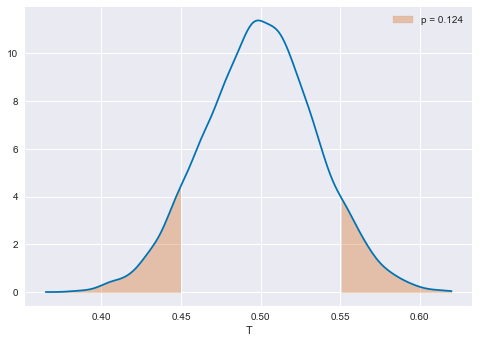

In [3]:
dist_muestreo = []
for i in range(10000):
    monedas_sim = np.random.choice([0, 1], size=n)
    caras_sim = np.sum(monedas_sim)
    T = caras_sim / n
    dist_muestreo.append(T)
y = np.array(dist_muestreo)

T_obs = caras_obs / n
valor_p = (np.sum(y[y < T_obs]) / np.sum(y)) * 2

kde = stats.gaussian_kde(y)
x = np.linspace(min(y), max(y), 200)
density = kde.pdf(x)

plt.plot(x, density)

plt.fill_between(x[x < T_obs], density[x < T_obs],
                 alpha=0.3, color='C2',
                 label='p = {:.3f}'.format(valor_p))
plt.fill_between(x[x > 1-T_obs], density[x > 1-T_obs],
                 alpha=0.3, color='C2')

plt.legend()
plt.xlabel('T');

#### Interpretando los resultados

Recapitulemos lo que acabamos de hacer es calcular la probabilidad de obtener 0, 1, ... 20 caras (barras azules), esto se llama _distribución de muestreo (sampling distribution)_. Y es la distribución de nuestro _estadístico_ $z$ para una muestra finita de $n=20$. 

Esta distribución es central en estadística frecuentista. De hecho a partir de ella hemos calculado la probabilidad de obtener 7 o menos caras (barras naranja), el _valor p_. 

¿Cómo se interpreta el _valor p_? 

Bueno, desde el punto de vista frecuentista las probabilidades viven en _asintópia_ un mundo donde las probabilidades son frecuencias que se obtienen en el límite de infinitas repeticiones de un mismo experimento. Entonces la interpretación sería:

    Si arrojaramos 20 veces al aire una moneda NO SESGADA y esto lo repetimos infinitas veces entonces el 13.2 % de las veces obtendremos 7 o menos caras. 

Es decir hemos encontrado la respuesta al pregunta ¿Cuán _esperable_ es este resultado para una moneda que _debería_ caer la mitad de las veces cara?

Otra pregunta _natural_ sería ¿Es realmente _diferente_ este resultado de $H_0$? Para dar respuesta a esta pregunta se suele usar el concepto (o "confupto" es decir concepto confuso) de significancia estadística, que consiste, como ya adelantamos, en comparar el _valor p_ con el valor predeterminado $\alpha$:

* Si p < 0.05, entonces la diferencia es estadísticamente significativa
* Si p < 0.001, entonces la diferencia es estadísticamente altamente-significativa

En este caso como p > 0.05 diríamos: "Se falla en rechazar la hipótesis nula con un p=0.132 y un nivel de significancia de 0.05".

Si esto suena a _rito umbanda_ es por que algo de eso hay! ¿De donde salen esos números? La verdad es que son arbritrarios y son casi consecuencia de accidentes históricos. Lamentablemente se ha vuelto muy común que estos límites se utilicen para definir si resultados son publicables o no. El límite dependerá de la revista/disciplina, siendo 0.05 común por ej en psicología y en varias ramas de la biología.

La intención de fijar un valor de $\alpha = 0.05$ es la de controlar el nivel de errores de tipo I. Es decir las falsas alarmas o más formalemente controlar la cantidad de veces que estamos dispuestos a rechazar una hipótesis nula verdadera (es decir una que NO deberíamos haber rechazado).

#### Valores p analíticos

Este problema puede ser resuelto de forma analítica, basta aplicar la distribución binomial ¿Por qué esta distribución? Precisamente por que modela eventos que tienen dos posibles resultados, cara-ceca, si-no, apagado-prendido, sano-enfermo, etc. La distribución binomial la vimos en el capítulo anterior y tiene la siguiente forma:  

$$p(x|n,p) = {\binom {n}{k}}p^x(1-p)^{n-x}$$


Hay que tener cuidado que $p$ en la distribución binomial NO es el _valor p_ del que estabamos hablando! Este es un buen momento para  volver al capítulo anterior y revisar _como es_ esta distribución.

Según el paradigma frecuentista el procedimiento sería:

1. Vamos a asumir que la moneda tiene la misma chance de caer cara (1) o ceca (0), p = 0.5
2. Vamos a lanzar una moneda 20 veces (igual que en nuestros datos), n = 20
3. Dados los puntos 1 y 2 y asumiendo que la moneda sigue una distribución binomial (con n=20, p =0.5) vamos a calcular la probabilidad de obtener 7 o menos caras. Esto es el *valor p*.

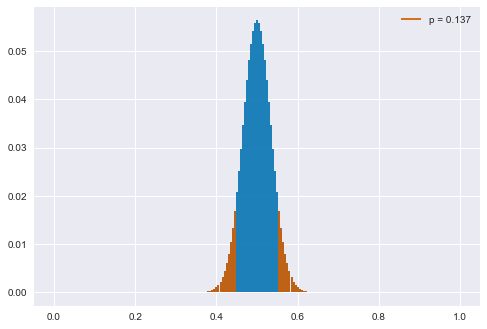

In [4]:
p = 0.5

dist_monedas = stats.binom(n, p);
x = np.arange(0, n + 1)
y = dist_monedas.pmf(x)

T = x/n
T_obs = caras_obs/n

valor_p = np.sum(y[T < T_obs]) * 2
plt.vlines(T, 0, y, 'C0')
plt.vlines(T[T < T_obs], 0, y[T < T_obs], 'C2',
           label='p = {:.3f}'.format(valor_p))
plt.vlines(T[T > 1-T_obs], 0, y[T > 1-T_obs], 'C2');

plt.legend();

#### Problemas con las prueba de hipótesis

Esta aproximación tiene varios problemas

1. Impone una forma de pensar dicotómica, que suele ser inapropiada en la mayoría de los estudios científicos.
2. Los *valor p* omiten muchos factores, información previa, nivel de precisión/incerteza de la estimación.
3. Un efecto estadísticamente significativo no tiene por que ser un efecto relevante.
4. Los _valores p_ dependen de las intenciones del observador! Si el experimento A es tirar $N$ veces una moneda y contar el número de caras y el experimento B es tirar una moneda hasta que obtener $z$ caras. El _valor p_ no necesariamente es el mismo aún si en ambos experimentos observamos que $N=10, z=7$). La razón es que las _distribuciones de muestro_ son diferentes en ambos casos, aún cuando los datos sean idénticos.
5. En general los *valores p* son interpretados erroneamente. Un trabajo mostró que solo el 62% de los encuestados fue capaz de contestar de forma correcta sobre la definición de los *valores p*. Lo interesante es que en realidad ninguna de las respuestas provistas en este estudio correspondía a una definición correcta de los _valores p_! Los *valores p* NO son:
    * La probabilidad de que $H_0$ sea cierta
    * La probabilidad de que $ no H_0$ falsa
    * La probabilidad de cometer un error al rechazar $H_0$
    * La probabilidad de que los datos observados se hayan dado por *azar*
    * Una forma de indicar que NO hay efecto si p > 0.5 (o el nivel que sea)
    * Una medida de la *relevancia* de un efecto.
    

Gran parte de los problemas derivados de los *valores p*, provienen de usarlos como parte de la maquinaria de "prueba de hipótesis nula". La otra parte del problema de usar los _valores p_ proviene quizá de que estos no derivan de un sistema formal de cálculo de probabilidades si no que fueron introducidos de forma totalmente _ad hoc_. Como veremos más adelante la Estadística Bayesiana provee de algo llamado factores de Bayes que curiosamente es todo lo que usted siempre quiso que un _valor p_ fuera, pero que el _valor p_ NO puede ser.

Una forma de usar los _valores p_ sin meter la pata es no pedirle que ofrezcan la información que no pueden ofrecer. Un _valor p_ debería ser usado con el fin que originalmente se postuló: Una forma aproximada, cuando se cuenta con poca información sobre un problema, para intentar estimar (de forma objetiva) si vale la pena seguir mirando los datos o haciendo experimentos a fin de replicar o extender resultados. Entonces en general valores "bajos" de los _valores p_ indicarían que es posible que tengamos algo interesante. Por ejemplo algunos autores recomiendan de forma _muuuy_ general interpretar los _valores p_ de la siguiente manera 

* p < 0.01 Hey parece que tenemos algo! :-)
* p > 0.1 humm al parecer no hay mucho que decir :-(
* 0.01 < p < 0.1 La vida rara vez nos ofrece respuestas claras! :-|

## Estimaciones puntuales e incerteza

En vez de poner a prueba hipótesis una alternativa es realizar inferencias sobre parámetros de un modelo estadístico. Estás estimaciones suelen incluir dos partes:

* Estimaciones puntuales
* Estimación de la incerteza asociada a la estimación puntual

### Estimación por maxima verosimilitud

Ahora veamos una alternativa a los valores *valores p* y la idea de la prueba de hipótesis, llamada estimación de maxima verosimilitud, o en inglés maximum likelihood estimation (MLE).

Para entender este método continuemos con el ejemplo de la moneda. Como dijimos podemos modelar este problema usando la distribución binomial. cuando $n=1$ la distribución binomial se convierte en la distribución de Bernoulli, la cual podemos escribir como:

$$f(x | p) = p^x(1-p)^{1-x}$$

donde como ya vimos $x \in [0,1]$.

Dado un conjunto de observaciones $x_1, x_2 ... x_n$, las cuales son indepentietes entre si (como las tiradas de una moneda) tendremos que es posible escribir: 

$$f(x_1, x_2 ... x_n | p) = p^x_1(1-p)^{1-x_1} p^x_2(1-p)^{1-x_2} ... p^x_n(1-p)^{1-x_n}$$

Esto que acabamos de escribir es el _likelihood_ (de nuestro modelo) el cual se puede escribir de forma más sintética como:

$$\mathcal{L}(p; x_1, x_2 ... x_n) = \prod_{i=1}^n p^x_i(1-p)^{1-x_i}$$

¿Cómo nos ayuda esta expresión a resolver nuestro problema? Bueno lo primero que hay que notar, y que he omitido hasta este momento, es que desconocemos el valor de $p$, de hecho esto es lo que queremos estimar. Lo cual se resuelve como un problema de optimización, queremos encontrar el valor de $p$ que maximiza el _likelihood_ (de ahí el nombre del método). Analíticamente esto se resulve haciendo

$$\frac{\partial \mathcal{L}}{\partial p} = 0$$

Es común usar el simbolo $\hat{}$ para indicar el valor del parámetro que maximiza el _likelihood_ en nuestro caso sería $\hat p$, o alternativamente $p_{MLE}$ (o incluso ambas notaciones en simultaneo).

En la práctica se suele usar el logaritmo del likelihood (log-likelihood), esto facilita los cálculos matemáticos, por ejemplo el producto se convierte en una suma. Esto también provee de ventajas numéricas, basicamente previene el _underflow_ que podría ocurrir al multiplicar sucesivas veces probabilidades (números entre 0 y 1).

Resulta que para nuestro modelo, el valor de $p$ que maximiza el likelihood es:

$$\hat p = \bar x$$

donde $\bar x = \frac{1}{n}\sum_i^n x$, es decir la media. Que siguiendo nuestra convención de llamar 0 a las cecas y 1 a las caras es también el número de caras dividido el número total de tiradas.

Por lo tanto para nuestro problema $\hat p$:

In [28]:
caras_obs / n

0.45

Una forma de corroborar que este es el valor de $p$ que maximiza al _likelihood_ (o _log-likelihood_) es usar el método de la grilla. Este método consiste simplemente en evaluar una función en varios puntos de una grilla (en general equidistantes). 
Entonces lo que vamos a hacer es dibujar el valor del _log-likelihood_ para varios valores de $p$, en todo el rango posible de valores de $p$.

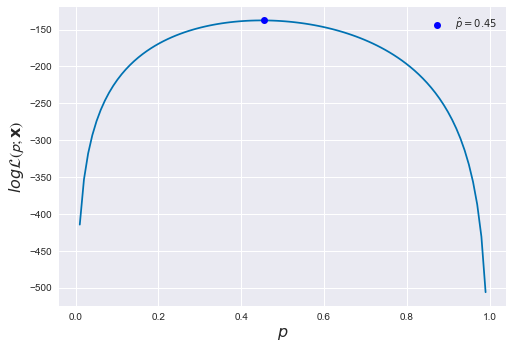

In [29]:
p = np.linspace(0, 1, 100)[1:-1]
ls = []
for i in p:
    dist = stats.binom(n=1, p=i)
    l = np.sum(dist.logpmf(monedas_obs))
    ls.append(l)

plt.plot(p, ls)
p_hat = p[np.argmax(ls)]
plt.plot(p[np.argmax(ls)], np.max(ls), 'bo',
         label='$\hat p ={:.2f}$'.format(p_hat))

plt.ylabel('$log\mathcal{L(p;\mathbf{x})}$', fontsize=16)
plt.xlabel('$p$', fontsize=16)
plt.legend();

### Intervalos de confianza

$\hat p$ es un ejemplo de estimación puntual, un número que usamos como estimación de un parámetro de una población. En este caso particular la media de la muestra como aproximación de la media de la población.

Suele ser buena idea acompañar la estimación puntual con una medida de la incertidumbre asociada a esa estimación. Una forma de medir esta incerteza es calculando lo que se conoce como **intervalo de confianza**. 

Este intervalo se puede construir a partir de la distribución de muestreo. A medida que $n$ aumenta el teorema del límite central garrantiza que dada una población con media finita $\mu$ y varianza finita (y distinta de zero) $\sigma^2$: 

$$\hat \mu = \mathcal{N}(\mu, \frac{\sigma^2}{n})$$

Entonces podemos definir un intervalo de confianza en términos de la estimación puntual y el error estandard (SE) de esa media:

$$IC = [\hat p - SE, \hat p + SE]$$

Este sería un intervalo de confianza de $\pm 1 SE$, si quisieramos ampliar o achica el rango podría usar $X$ errores estándar, por ejemplo:

$$IC = [\hat p - X SE, \hat p + X SE]$$

En la práctica es común que la gente defina los $IC$ en términos de porcentajes y no $SE$, de hecho el porcentaje más comumente usadado es 95%. Convertir entre porcentajes y $SE$ es simple si asumimos que la distribución es Gaussiana. En ese caso es conocido que un intervalo del 95% estará de forma paroximadad dentro de 1.96 errores estandard (o lo que es lo mismo un Z-score de 1.96).

Podemos usar el siguiente código para pasar de porcentajes a _cantidades_ de $SE$

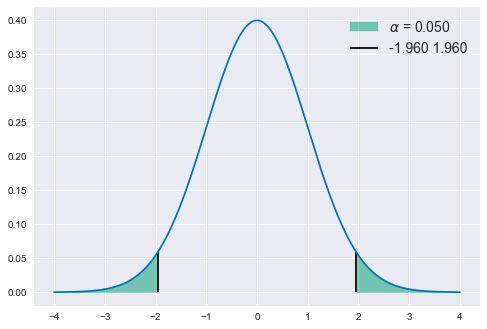

In [26]:
c = 95
a = (100 - c) / 100
gaussian = stats.norm(0, 1)
l, u = gaussian.ppf([(a / 2), (1 - a / 2)])
x = np.linspace(-4, 4, 300)
y = gaussian.pdf(x)
plt.plot(x, y);
plt.fill_between(x[x < l], y[x < l], alpha=0.5, color='C1')
plt.fill_between(x[x > u], y[x > u], alpha=0.5, color='C1',
                label='$\\alpha$ = {:.3f}'.format(a))

plt.vlines([l, u], 0, gaussian.pdf([l,u]),
          label='{:.3f} {:.3f}'.format(l, u))

plt.legend(fontsize=14);

Dada la definición de $IC$ y el hecho que usando $\pm 1.96$ errores estándard podemos definir un intervalo de confianza del 95%, usemos Python para calcularlo.

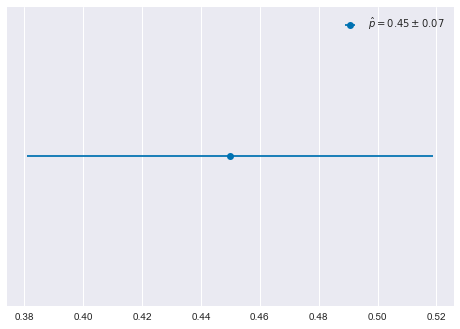

In [30]:
p_hat = caras_obs/n
dist_monedas = stats.binom(n=1, p=p_hat)
std_error =  dist_monedas.std() / n**0.5
r = std_error * 1.96  

plt.errorbar(x=p_hat, y=0,
             xerr=r,
             fmt='o',
            label='$\hat p = {:.2f} \pm {:.2f}$'.format(p_hat, r))
plt.yticks([])
plt.legend();

Como ya dijimos es muy común usar un intervalo con un *nivel de confianza* del 95%. Pero este valor es arbitrario, tan arbritrario como el valor de $\alpha$ en las pruebas de hipótesis. De hecho ambos valores están relacionados.

Esencialmente un intervalo de confianza contiene a todos los valores de $\hat p$ para los cuales $H_0$ NO sería rechazada, para un dado valor de $\alpha$. Los intervalos de confianza se suelen expresar como $(1 - \alpha) 100 %$, por lo que un valor de $\alpha=0.05$ se relaciona con un intervalo de confianza de 95%.

Como sucede con los _valores p_ resulta que es facil interpretar los $IC$ de forma erronea. Por ello veamos cual es la interpretación adecuada.

Si repetimos un experimento (infinitas veces) y cada vez calculamos un intervalo de confianza, entonces obtendremos que el X% de esos intervalos contendran el valor _real_ del parámetro de interés.
Es decir el nivel de confianza, digamos el 95%, NO es sobre un intervalo en particular es sobre todo el universo posible de intervalos que se podrían calcular con muestras simialares a la nuestra. Por lo tanto NO es posible decir que tenemos una confianza del 95% que NUESTRO intervalo contenga el parámetro, en sentido estricto nuestro intervalo o contiene o no contiene al parámetro _real_. Si quisieramos hacer enunciados como tengo un 95% de confianza que el parámetro real se encuentra en tal o cual rango, deberé hacer uso de estadística Bayesiana!

### Bootstrapping

* Mostrar como usar bootstrtaping con la regresión lineal?
* Mostrar minimos cuadrados como caso particular de MLE?

## Ejercicios

1. graficar dist_monedas.cdf() en el rango de 0 a 20. Luego lo mismo pero para un n más grande  por ejmplo 1000